In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# General Modeling
from scipy import stats
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit
import itertools

# Specific Modeling: Classification Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import plotly.express as px

In [ ]:
crimes = pd.read_csv('/content/drive/MyDrive/Bad_landlords/tmpdfeo3qy2.csv', encoding='windows-1254')
offense_codes = pd.read_csv('/content/drive/MyDrive/Bad_landlords/offense_codes.csv', encoding='windows-1254')

In [ ]:
crimes_complete = crimes.merge(offense_codes, left_on='OFFENSE_CODE', right_on='CODE', how='left') \
                        .drop('CODE', axis='columns')

crimes_complete.head(5)

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location,NAME
0,222076257,619,NaN,LARCENY ALL OTHERS,D4,167,0,2022-01-01 00:00:00,2022,1,Saturday,0,NaN,HARRISON AVE,42.339542,-71.069409,"(42.33954198983014, -71.06940876967543)",LARCENY ALL OTHERS
1,222076257,619,NaN,LARCENY ALL OTHERS,D4,167,0,2022-01-01 00:00:00,2022,1,Saturday,0,NaN,HARRISON AVE,42.339542,-71.069409,"(42.33954198983014, -71.06940876967543)",LARCENY OTHER $200 & OVER
2,222053099,2670,NaN,HARASSMENT/ CRIMINAL HARASSMENT,A7,,0,2022-01-01 00:00:00,2022,1,Saturday,0,NaN,BENNINGTON ST,42.377246,-71.032597,"(42.37724638479816, -71.0325970804128)",CRIMINAL HARASSMENT
3,222053099,2670,NaN,HARASSMENT/ CRIMINAL HARASSMENT,A7,,0,2022-01-01 00:00:00,2022,1,Saturday,0,NaN,BENNINGTON ST,42.377246,-71.032597,"(42.37724638479816, -71.0325970804128)",CRIMINAL HARRASSMENT
4,222039411,3201,NaN,PROPERTY - LOST/ MISSING,D14,778,0,2022-01-01 00:00:00,2022,1,Saturday,0,NaN,WASHINGTON ST,42.349056,-71.150498,"(42.34905600030506, -71.15049849975023)",PROPERTY - LOST


In [ ]:
print('Duplication (%)', 
      100*(len(crimes_complete) - 
           len(crimes_complete.drop_duplicates()))/len(crimes_complete), '%')

Duplication (%) 26.74563737842357 %


In [ ]:


crimes_complete.drop_duplicates(inplace=True)



In [ ]:
# Cast category
crimes_complete = crimes_complete.astype({'OFFENSE_CODE_GROUP': 'category', 
                                          'OFFENSE_DESCRIPTION': 'category', 'DISTRICT': 'category', 
                                          'REPORTING_AREA': 'category', 'DAY_OF_WEEK': 'category', 
                                          'UCR_PART': 'category', 'NAME': 'category'})

crimes_complete['SHOOTING'] = pd.Series(['Yes' if s=='Y' else 'No' 
                                         for s in crimes_complete['SHOOTING']]) \
                                .astype('category')
crimes_complete['SHOOTING'].fillna('No', inplace=True)
    # Some 'No' values got converted back to null so have to reconvert them back to 'No'

crimes_complete['MONTH'] = crimes_complete['MONTH'].replace({1: 'January', 2: 'February', 
                                                             3: 'March', 4: 'April', 5: 'May', 
                                                             6: 'June', 7: 'July', 8: 'August', 
                                                             9: 'September', 10: 'October', 
                                                             11: 'November', 
                                                             12: 'December'}).astype('category')

# Cast datetime and string
crimes_complete = crimes_complete.astype({'OCCURRED_ON_DATE': 'datetime64[ns]', 
                                          'INCIDENT_NUMBER': 'string', 
                                          'STREET': 'string', 'Location': 'string'})

In [ ]:


# View its summary statistics for numerical fields
crimes_complete.describe()



,OFFENSE_CODE,YEAR,HOUR,Lat,Long
count,93318.000000,93318.0,93318.000000,88383.000000,88383.000000
mean,2070.856384,2022.0,12.677308,42.323505,-71.084121
std,1245.731188,0.0,6.560437,0.032236,0.031892
min,111.000000,2022.0,0.000000,42.214410,-71.349470
25%,619.000000,2022.0,9.000000,42.297555,-71.100574
50%,1832.000000,2022.0,13.000000,42.328743,-71.077336
75%,3115.000000,2022.0,18.000000,42.349056,-71.060880
max,3831.000000,2022.0,23.000000,42.461410,-70.953726


In [ ]:
crimes_complete.drop(crimes_complete.describe(), axis='columns').describe()

,INCIDENT_NUMBER,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,MONTH,DAY_OF_WEEK,UCR_PART,STREET,Location,NAME
count,93318,0,93318,93113,93318,93318,93318,93318,93318,0,93317,88383,92884
unique,73852,0,120,13,846,1,59770,12,7,0,8377,12542,155
top,222076257,NaN,INVESTIGATE PERSON,D4,,No,2022-08-27 00:00:00,July,Friday,NaN,WASHINGTON ST,"(42.29755532959655, -71.05970910242573)",INVESTIGATE PERSON
freq,2,NaN,8070,12737,55487,93318,40,8549,14283,NaN,8078,3428,8070
first,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,2022-12-31 23:50:00,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:


crimes_complete['INCIDENT_NUMBER'].value_counts()



222076257    2
222063379    2
222073458    2
222063136    2
222063154    2
            ..
222096146    1
222096145    1
222096055    1
222096203    1
232000052    1
Name: INCIDENT_NUMBER, Length: 73852, dtype: Int64

In [ ]:
crimes_complete['OFFENSE_CODE_GROUP'].value_counts()

Series([], Name: OFFENSE_CODE_GROUP, dtype: int64)

Which district has the most/least number of reported crimes?


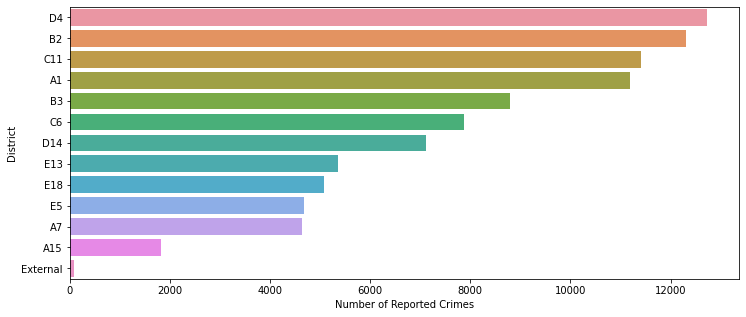

In [ ]:
sns.barplot(data=crimes_complete['DISTRICT'].value_counts().reset_index(), 
            x='DISTRICT', y='index', 
            order=crimes_complete['DISTRICT'].value_counts().reset_index()['index'])

plt.xlabel('Number of Reported Crimes')
plt.ylabel('District')
plt.gcf().set_size_inches(12, 5)

plt.show()

Are the severity of the crimes different between district D4 and A15?

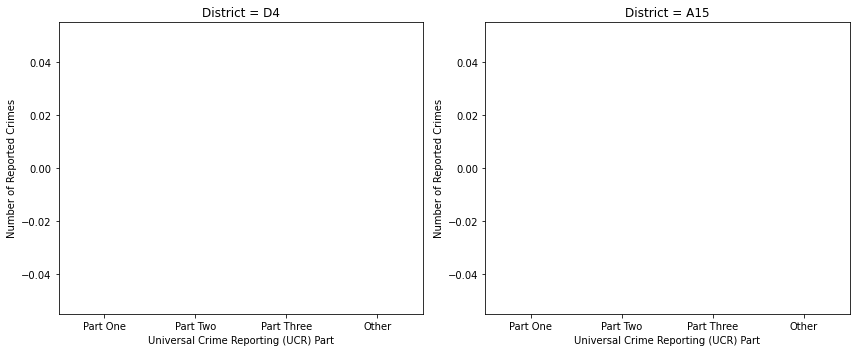

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(ax = axes[0], data=crimes_complete.loc[crimes_complete['DISTRICT']=='D4', 
                                                   'UCR_PART'].value_counts().reset_index(), 
            x='index', y='UCR_PART', 
            order=['Part One', 'Part Two', 'Part Three', 'Other'])
axes[0].set(xlabel='Universal Crime Reporting (UCR) Part', 
            ylabel='Number of Reported Crimes', title='District = D4')

sns.barplot(ax = axes[1], data=crimes_complete.loc[crimes_complete['DISTRICT']=='A15', 
                                                   'UCR_PART'].value_counts().reset_index(), 
            x='index', y='UCR_PART',
            order=['Part One', 'Part Two', 'Part Three', 'Other'])
axes[1].set(xlabel='Universal Crime Reporting (UCR) Part', 
            ylabel='Number of Reported Crimes', title='District = A15')

plt.tight_layout()

plt.show()